In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

figure_path = os.path.join(os.getcwd(), "report", "figures")
data_path = os.path.join(os.getcwd(), "data")

### Calibration of the single channel analyzer
we first plot the measurement of the Fe-57 spectrum that we performed for the calibration.
- We compare between the count and the LLD, which controls the lower limit in which the counts should be observed, i.e. the 

In [2]:
calib_data = np.genfromtxt(os.path.join(data_path, "calibration_moessbauer.csv"), delimiter=",", skip_header=1)
# LLD, count, time, ULD (Delta E = 100%)
lld_data, count_data = calib_data[:,0], calib_data[:,1]

# the time and uld value were the same for each measurement,
# so just take the value from first index
duration, uld_val = calib_data[0,2], calib_data[0,3]

# take error in counts to be purely statistical
counts_err = np.sqrt(count_data)

# print(count_data)

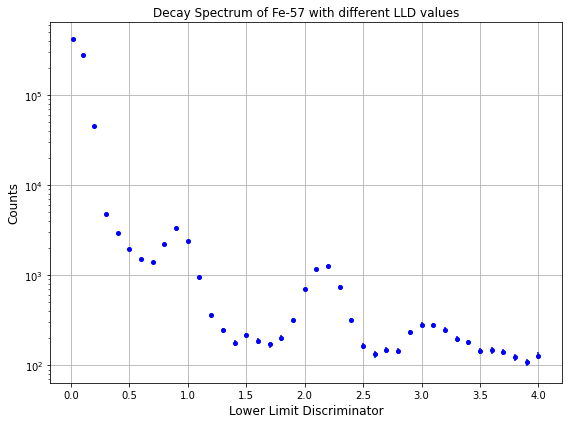

In [3]:
# plot the LLD vs count
fig, ax = plt.subplots(figsize=(8,6), tight_layout=True)
ax.errorbar(lld_data, count_data, yerr=counts_err, marker="o", color="b", ls="", ms=4.0)
ax.set_xlabel("Lower Limit Discriminator", fontsize=12)
ax.set_ylabel("Counts", fontsize=12)
ax.set_title("Decay Spectrum of Fe-57 with different LLD values")
ax.set_yscale("log")
ax.grid()


# to say something about it, compare to the figure 4.14 in the textbook reference
# that way we can identify this as the 14.4 keV Moessbauer line
# not sure what else to do here, so moving on for now
plt.savefig(os.path.join(figure_path, "calib_plot.png"), dpi=300)

### Looking at hyperfine structure of Moessbauer line (14.4keV transition)
- plot the results
- perform curve fit (from eq)

In [9]:
# get data for LR and RL respectively
moess_lr_data = np.genfromtxt(os.path.join(data_path, "velocity_LR_moessbauer.csv"), delimiter=",", skip_header=1)
moess_rl_data = np.genfromtxt(os.path.join(data_path, "velocity_RL_moessbauer.csv"), delimiter=",", skip_header=1)

# modify time to be counts per second
moess_lr_data[:,3] *= 1e-3
moess_rl_data[:,3] *= 1e-3

time_err = 0.003 * 1000

# structure: velocity, motor speed (for reference), counts, time, number of turns
# the velocity is calculated from time and number of turns
# we plot count rate so we need velocity, counts and time

# vel_lr_arr, counts_lr_arr = moess_lr_data[:,0], moess_lr_data[:,2]
# vel_rl_arr, counts_rl_arr = moess_rl_data[:,0], moess_rl_data[:,2]

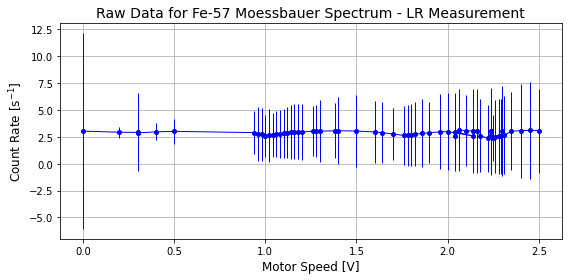

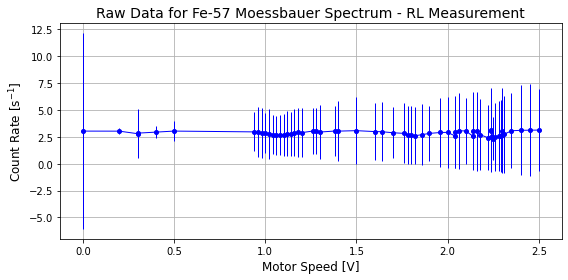

In [12]:
# plot our results (to check)
moess_raw_datas = [moess_lr_data, moess_rl_data]
labels = ["LR", "RL"]

for i, moess_raw_data in enumerate(moess_raw_datas):
    count_rate_err = moess_raw_data[:,5] * np.sqrt( (np.sqrt(moess_raw_data[:,2]) / moess_raw_data[:,2])**2. + (time_err / moess_raw_data[:,3])**2.)


    fig, ax = plt.subplots(figsize=(8,4), tight_layout=True)
    ax.errorbar(moess_raw_data[:,1], moess_raw_data[:,5], yerr=count_rate_err, marker="o", ls="-", lw=1.0, ms=4.0, color="b")
    ax.set_xlabel("Motor Speed [V]", fontsize=12)
    ax.set_ylabel("Count Rate [s$^{{-1}}]$", fontsize=12)
    ax.set_title("Raw Data for Fe-57 Moessbauer Spectrum - {0} Measurement".format(labels[i]), fontsize=14)
    ax.grid()


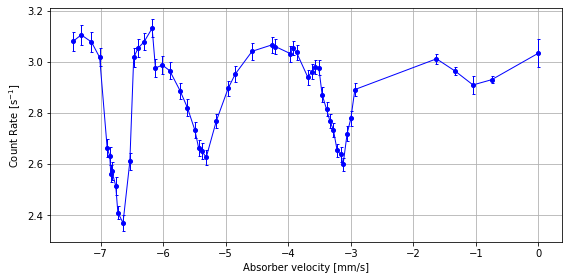

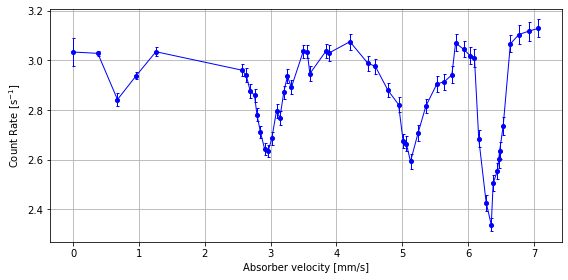

In [71]:
# remove the outliers
# looking at the numbers from apple, we have to remove:
# 7, 14, 15, 22, 24, 58, for lr
# 4, 39, 43, 49, 50, 55,  for rl
# all indices we count from 2 (contrary to python), so we need to shift index by 2

lr_outliers_idces = np.array([7, 13, 14, 15, 22, 24, 58]) - 2
rl_outliers_idces = np.array([4, 39, 43, 48, 49, 50, 55]) - 2

outliers_idces = [lr_outliers_idces, rl_outliers_idces]

moess_datas_filt = []

# perform error analysis here
time_err = 0.003   # uncertantity in time measurement

for i, moess_raw_data in enumerate(moess_raw_datas):
    moess_data_filt = np.delete(moess_raw_data, outliers_idces[i], axis=0)

    # get the corresponding values
    vel, counts, time, count_rate = moess_data_filt[:,0], moess_data_filt[:,2], \
                                        moess_data_filt[:,3], moess_data_filt[:,5]

    # error (from sample report)
    # i think they apply error propagation to N / T
    counts_err = np.sqrt(counts)

    count_rate_err = count_rate * np.sqrt( (counts_err / counts)**2. + (time_err / time)**2.)

    fig, ax = plt.subplots(figsize=(8,4), tight_layout=True)
    ax.errorbar(vel, count_rate, yerr=count_rate_err, marker="o", ls="-", lw=1.0, ms=4.0, color="b", capsize=1.5)
    ax.set_xlabel("Absorber velocity [mm/s]")
    ax.set_ylabel("Count Rate [s$^{{-1}}$]")
    ax.grid()

    moess_data_new = np.zeros((len(vel), 7))
    moess_data_new[:,:6] = moess_data_filt
    moess_data_new[:,-1] = count_rate_err

    # append filtered data for future use
    moess_datas_filt.append(moess_data_new)

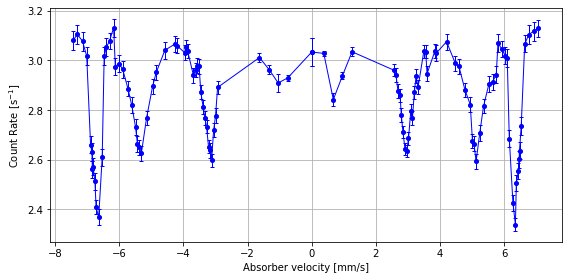

In [8]:
# combine the data
moess_data_comb = np.concatenate(moess_datas_filt, axis=0)

vel, count_rate, count_rate_err = moess_data_comb[:,0], moess_data_comb[:,5], moess_data_comb[:,6]




fig, ax = plt.subplots(figsize=(8,4), tight_layout=True)
ax.errorbar(vel, count_rate, yerr=count_rate_err, marker="o", ls="-", lw=1.0, ms=4.0, color="b", capsize=2.0)
ax.set_xlabel("Absorber velocity [mm/s]")
ax.set_ylabel("Count Rate [s$^{{-1}}$]")
ax.grid()


In [61]:
# perform fit for Moessbauer spectrum

from scipy.optimize import curve_fit, least_squares

def lorentzian(x, x0, A, gamma):
    '''Single Lorentzian function: 
    A - amplitude, x0 - center of peak, gamma /2 - width of peak'''
    return -A  * (gamma / 2)**2. / ((gamma / 2)**2. + (x - x0)**2.)

def multi_lorentzian(x, offset, lorentz_params):
    '''
    Combination of Lorentzian functions.
    params contain: 
        [offset, each (x0, A, gamma) for each peak]
    '''
    # print(params)
    # offset = params[0]   # offset, for isomer shift
    # lorentzian parameters; need to index first element since how we construct parameter
    # list is a double list
    # lorentz_params = params[1:]  # lorentzian parameters

    # print(offset, lor_params, lor_params[0])

    # below honestly not needed
    # Npeaks = len(lor_params)  

    # for lor_param in lor_params:
    #     print(lor_param)
    
    # print([lorentzian(x, *lor_param) for lor_param in lor_params])
    # print(np.sum([lorentzian(x, *lor_param) for lor_param in lor_params], axis=0))

    # sum over 0th axis since we sum over each lorentzian, not over x-values
    return offset + np.sum([lorentzian(x, *lorentz_param) for lorentz_param in lorentz_params], axis=0)

def residual_multi_lorentz(x, *params):
    xdata = params[0]
    ydata = params[1]
    yerr = params[2]
    offset = params[3]
    lorentz_params = params[4:]

    return np.sum( (ydata - multi_lorentzian(xdata, offset, lorentz_params))**2. / yerr**2.)


# def wrapper_multi_lorentzian(x, *params):
#     '''Wrapper so that we can pass parameter list easier and adjust with curve_fit easier'''
#     offset = params[0]


# initial guesses
offset_guess = [0.5]   # list so that combining parameters is easier
# from left to right
lorentz_guess = [
    (-6.75, 2.35, 0.5), (-5.25, 2.61, 0.75), (-3.1, 2.6, 0.5), (-1., 2.9, 1.),
    (0.75, 2.85, 0.75), (3., 2.62, 0.5), (5.2, 2.6, 0.65), (6.2, 2.34, 0.5)
]

params0 = offset_guess + lorentz_guess
# print(params0)

# print(len(params0))
# check that our multi_lorentzian function works
# vel_test = np.linspace(-10, 10, 1000)
# plt.plot(vel_test, multi_lorentzian(vel_test, *params0))

moess_data_comb = np.array(moess_data_comb, dtype=np.float64)
vel, count_rate, count_rate_err = moess_data_comb[:,0], moess_data_comb[:,5], moess_data_comb[:,6]

# perform fitting
# popt, pcov = curve_fit(multi_lorentzian, vel, count_rate, p0=params0, sigma=count_rate_err, maxfev=5000)





[0.5, (-6.75, 2.35, 0.5), (-5.25, 2.61, 0.75), (-3.1, 2.6, 0.5), (-1.0, 2.9, 1.0), (0.75, 2.85, 0.75), (3.0, 2.62, 0.5), (5.2, 2.6, 0.65), (6.2, 2.34, 0.5)]
<class 'float'> <class 'float'> <class 'float'>
<class 'float'> <class 'float'> <class 'float'>
<class 'float'> <class 'float'> <class 'float'>
<class 'float'> <class 'float'> <class 'float'>
<class 'float'> <class 'float'> <class 'float'>
<class 'float'> <class 'float'> <class 'float'>
<class 'float'> <class 'float'> <class 'float'>
<class 'float'> <class 'float'> <class 'float'>


TypeError: Cannot cast array data from dtype('O') to dtype('float64') according to the rule 'safe'

In [65]:
# perform fit for Moessbauer spectrum

from scipy.optimize import curve_fit

def lorentzian(x, x0, A, gamma):
    '''Single Lorentzian function: 
    A - amplitude, x0 - center of peak, gamma /2 - width of peak'''
    print(type(A), type(gamma), type(x0))
    return -A  * (gamma / 2)**2. / ((gamma / 2)**2. + (x - x0)**2.)

def multi_lorentzian(x, *params):
    '''
    Combination of Lorentzian functions.
    params contain: 
        [offset, each (x0, A, gamma) for each peak]
    '''
    # print(params)
    offset = params[0]   # offset, for isomer shift
    # lorentzian parameters; need to index first element since how we construct parameter
    # list is a double list
    lor_params = params[1:]  # lorentzian parameters

    # print(offset, lor_params, lor_params[0])

    # below honestly not needed
    # Npeaks = len(lor_params)  

    # for lor_param in lor_params:
    #     print(lor_param)
    
    # print([lorentzian(x, *lor_param) for lor_param in lor_params])
    # print(np.sum([lorentzian(x, *lor_param) for lor_param in lor_params], axis=0))

    # sum over 0th axis since we sum over each lorentzian, not over x-values
    return offset + np.sum([lorentzian(x, *lor_param) for lor_param in lor_params], axis=0, dtype=np.float64)

# def wrapper_multi_lorentzian(x, *params):
#     '''Wrapper so that we can pass parameter list easier and adjust with curve_fit easier'''
#     offset = params[0]


# initial guesses
offset_guess = [0.5] # list so that combining parameters is easier
# from left to right
lorentz_guess = [
    np.array([-6.75, 2.35, 0.5], dtype=np.float64), np.array([-5.25, 2.61, 0.75], dtype=np.float64), np.array([-3.1, 2.6, 0.5], dtype=np.float64), np.array([-1., 2.9, 1.], dtype=np.float64),
    np.array([0.75, 2.85, 0.75], dtype=np.float64), np.array([3., 2.62, 0.5], dtype=np.float64), np.array([5.2, 2.6, 0.65], dtype=np.float64), np.array([6.2, 2.34, 0.5], dtype=np.float64)
]

params0 = offset_guess + lorentz_guess
print(params0)

# print(len(params0))
# check that our multi_lorentzian function works
# vel_test = np.linspace(-10, 10, 1000)
# plt.plot(vel_test, multi_lorentzian(vel_test, *params0))

moess_data_comb = np.array(moess_data_comb, dtype=np.float64)
vel, count_rate, count_rate_err = moess_data_comb[:,0], moess_data_comb[:,5], moess_data_comb[:,6]

# perform fitting
popt, pcov = curve_fit(multi_lorentzian, vel, count_rate, p0=params0, sigma=count_rate_err, maxfev=5000)



[0.5, array([-6.75,  2.35,  0.5 ]), array([-5.25,  2.61,  0.75]), array([-3.1,  2.6,  0.5]), array([-1. ,  2.9,  1. ]), array([0.75, 2.85, 0.75]), array([3.  , 2.62, 0.5 ]), array([5.2 , 2.6 , 0.65]), array([6.2 , 2.34, 0.5 ])]
<class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>
<class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>
<class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>
<class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>
<class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>
<class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>
<class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>
<class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>


c:\Users\voltk\Anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


TypeError: Cannot cast array data from dtype('O') to dtype('float64') according to the rule 'safe'

<ipython-input-11-876306b39d49>:21: RuntimeWarning: divide by zero encountered in true_divide
  en = Gamma0 / (vel / c)


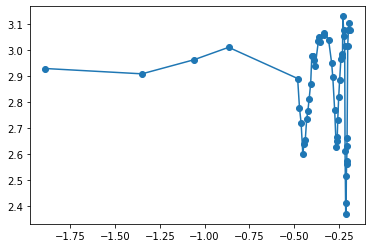

In [11]:
# perform fit
# to do this, we fit to a Lorentzian function 

# honestly kinda lost atm...

# define relevant constants here
# hbar = 1.05457182e-34 # J s
hbar = 6.58211957e-16  # eV s
c = 3e8  # m/s
Gamma0 = 4.7e-9  # in eV

def fit_func(E, I0, E0, Gamma):
    return I0  / (1 + (2 * (E - E0) / Gamma)**2.)

# convert velocity into photon transition energy

for i, moess_data in enumerate(moess_datas[:1]):
    vel = moess_data[:,0]
    count_rate = moess_data[:,2] / moess_data[:,3]

    en = Gamma0 / (vel / c)
    plt.plot(en, count_rate, marker="o")



In [ ]:
# found this code online for multi-lorentzian fit
# not sure how to fit for our data because still not used to
# the numpy notations you are using

from scipy.optimize import leastsq

def lorentzian( x, x0, a, gam ):
    return a * gam**2 / ( gam**2 + ( x - x0 )**2)

def multi_lorentz( x, params ):
    off = params[0]
    paramsRest = params[1:]
    assert not ( len( paramsRest ) % 3 )
    return off + sum( [ lorentzian( x, *paramsRest[ i : i+3 ] ) for i in range( 0, len( paramsRest ), 3 ) ] )

def res_multi_lorentz( params, xData, yData ):
    diff = [ multi_lorentz( x, params ) - y for x, y in zip( xData, yData ) ]
    return diff

xData, yData = np.loadtxt('HEMAT_1.dat', unpack=True )
yData = yData / max(yData)

generalWidth = 1

yDataLoc = yData
startValues = [ max( yData ) ]
counter = 0

while max( yDataLoc ) - min( yDataLoc ) > .1:
    counter += 1
    if counter > 20: ### max 20 peak...emergency break to avoid infinite loop
        break
    minP = np.argmin( yDataLoc )
    minY = yData[ minP ]
    x0 = xData[ minP ]
    startValues += [ x0, minY - max( yDataLoc ), generalWidth ]
    popt, ier = leastsq( res_multi_lorentz, startValues, args=( xData, yData ) )
    yDataLoc = [ y - multi_lorentz( x, popt ) for x,y in zip( xData, yData ) ]

print popt
testData = [ multi_lorentz(x, popt ) for x in xData ]

fig = plt.figure()
ax = fig.add_subplot( 1, 1, 1 )
ax.plot( xData, yData )
ax.plot( xData, testData )
plt.show()
